In [2]:
import csv
import os
# Plotting
import matplotlib.pyplot as plt

In [7]:
# This cell:
#  - defines functions to compute the tables,
#  - computes them for N=5, a=3, b=2, x=1, y=0 (same example you used),

# Output directory for images and csv
out_dir = "./experiments"
os.makedirs(out_dir, exist_ok=True)

import conditioned_random_walk as rw 
rw.set_out_dir(out_dir)

# ---------------------------
# PARAMETERS (change here)
# ---------------------------
N = 10
a = 1.030303
b = 1.781818
x = -0.406061
y = 0.406061

# Bounds (functions)
lower_bound = lambda n: -b - n * y
upper_bound = lambda n: a + n * x


# ---------------------------
# Run computations
# ---------------------------
paths_remaining, p_up, opt_value, valid = rw.compute_paths_probs_values(N, lower_bound, upper_bound)
reachable = rw.compute_reachability(N, valid)
threshold_all, threshold_reach = rw.compute_thresholds(N, opt_value, valid, reachable)

-1 1
-2 0
-2 0
-3 -1
-3 -1
-3 -2
-4 -2
-4 -2
-5 -3
-5 -3
-5 -4


Plot saved to: ./experiments/optstop_example_plot.png


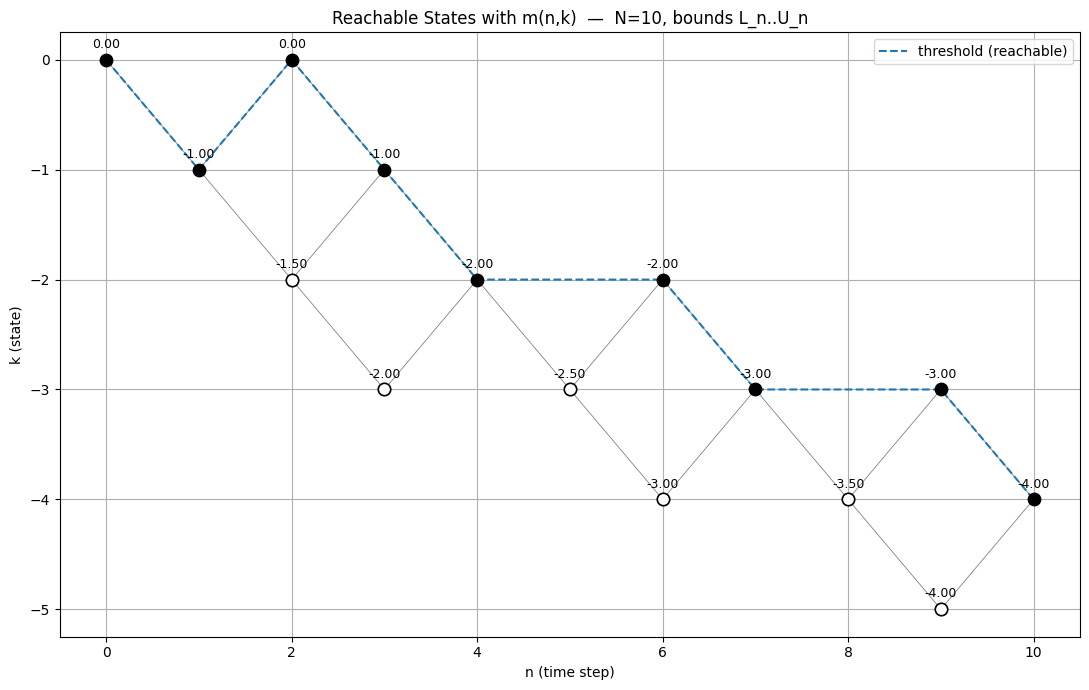

In [8]:
# This cell:
#  - saves a plot showing reachable nodes and stopping decisions.
#

# ---------------------------
# Plotting: figure for the report
# ---------------------------
fig, ax = plt.subplots(figsize=(11,7))

# Plot thin gray edges for reachable transitions
for n in range(N):
    for k in valid[n]:
        if not reachable[n].get(k, 0):
            continue
        if reachable[n+1].get(k+1, 0):
            ax.plot([n, n+1], [k, k+1], color="gray", linewidth=0.6)
        if reachable[n+1].get(k-1, 0):
            ax.plot([n, n+1], [k, k-1], color="gray", linewidth=0.6)

# Plot nodes and labels: filled black if opt_value==k (stop), hollow otherwise
for n in range(N + 1):
    for k in valid[n]:
        if not reachable[n].get(k, 0):
            continue
        val = opt_value.get((n, k), float('nan'))
        # is_stop = abs(val - k) < 1e-12
        is_stop = abs(val - k) < 1e-12
        if is_stop:
            ax.scatter(n, k, s=80, color="black", zorder=3)
        else:
            ax.scatter(n, k, s=80, facecolors="white", edgecolors="black", linewidth=1.2, zorder=3)
        # label
        ax.text(n, k + 0.08, f"{val:.2f}", ha='center', va='bottom', fontsize=9, zorder=4)

# Annotate thresholds (reachable) as a dotted line connecting minimal stopping k per time where defined
xs = []
ys = []
for n in range(N + 1):
    t = threshold_reach[n]
    if t is not None:
        xs.append(n)
        ys.append(t)
if xs:
    ax.plot(xs, ys, linestyle="--", linewidth=1.5, label="threshold (reachable)")

ax.set_xlabel("n (time step)")
ax.set_ylabel("k (state)")
ax.set_title(f"Reachable States with m(n,k)  —  N={N}, bounds L_n..U_n")
ax.grid(True)
ax.legend()

plt.tight_layout()
img_path = os.path.join(out_dir, "optstop_example_plot.png")
plt.savefig(img_path, dpi=300)
print("Plot saved to:", img_path)

# If pandas not available, print a small textual table for inspection
# if not HAVE_PANDAS:
#     print("\nSmall table (n,k, paths_remaining, p_up, opt_value, reachable) sample (first 40 rows):")
#     for r in rows[:40]:
#         rw.log("full_table_row", r)



In [14]:
# This cell:
#  - saves CSVs and summary.
#

rw.log("Start", {"ok" : 1}, "w")

# ---------------------------
# Prepare tables for reporting
# ---------------------------
rows = []
for n in range(N + 1):
    for k in valid[n]:
        rows.append({
            'n': n,
            'k': k,
            'paths_remaining': paths_remaining.get((n, k), 0),
            'p_up': None if n == N else round(p_up.get((n, k), 0.0), 6),
            'opt_value': round(opt_value.get((n, k), float('nan')), 9),
            'reachable': bool(reachable[n].get(k, 0))
        })
    
# Also write CSVs for later inspection
csv_path = os.path.join(out_dir, "paths_probs_values.csv")
with open(csv_path, "w", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=['n', 'k', 'paths_remaining', 'p_up', 'opt_value', 'reachable'])
    writer.writeheader()
    for r in rows:
        writer.writerow(r)

# ---------------------------
# Print summary
# ---------------------------
print("Computed tables saved to:", csv_path)
print("\nSummary of admissible states and reachability saved to logs")
rw.log("admissible_state_summary", {
    "n": n,
    "lower_bound": lower_bound(n),
    "upper_bound": upper_bound(n),
    "valid_states": valid[n],
    "reachable_states": [k for k in valid[n] if reachable[n].get(k, 0)]
})

print("\nSample of nonzero paths_remaining (n,k,count) saved to logs")
for (n,k),cnt in sorted(paths_remaining.items()):
    if cnt > 0:
        rw.log("paths_remaining", {"n": n, "k": k, "count": cnt})

print("\nThresholds (all / reachable):")
for n in range(N + 1):
    print(f"  n={n}: threshold_all = {threshold_all[n]}, threshold_reachable = {threshold_reach[n]}")
rw.log("thresholds", {
    "threshold_all": threshold_all,
    "threshold_reach": threshold_reach
})

# Make the results summary
result_summary = {
    "csv_path": csv_path,
    "img_path": img_path,
    "paths_remaining": paths_remaining,
    "p_up": p_up,
    "opt_value": opt_value,
    "valid": valid,
    "reachable": reachable,
    "threshold_all": threshold_all,
    "threshold_reach": threshold_reach
}

#log("result_summary", result_summary)

print("Computation completed.")
print("CSV saved to:", csv_path)
print("Plot saved to:", img_path)
print("Log saved to:", rw.log_path)


Computed tables saved to: ./experiments/paths_probs_values.csv

Summary of admissible states and reachability saved to logs

Sample of nonzero paths_remaining (n,k,count) saved to logs

Thresholds (all / reachable):
  n=0: threshold_all = -2, threshold_reachable = 0
  n=1: threshold_all = -1, threshold_reachable = -1
  n=2: threshold_all = -1, threshold_reachable = 0
  n=3: threshold_all = 0, threshold_reachable = None
  n=4: threshold_all = 0, threshold_reachable = None
  n=5: threshold_all = 0, threshold_reachable = None
  n=6: threshold_all = None, threshold_reachable = None
  n=7: threshold_all = None, threshold_reachable = None
  n=8: threshold_all = None, threshold_reachable = None
  n=9: threshold_all = None, threshold_reachable = None
  n=10: threshold_all = None, threshold_reachable = None
Computation completed.
CSV saved to: ./experiments/paths_probs_values.csv
Plot saved to: ./experiments/optstop_example_plot.png
Log saved to: ./experiments/run_log.jsonl


In [5]:
p_up

{(0, -2): 0.0,
 (0, -1): 0.0,
 (0, 0): 0.0,
 (0, 1): 0.0,
 (0, 2): 0.0,
 (0, 3): 0.0,
 (1, -1): 0.0,
 (1, 0): 0.0,
 (1, 1): 0.0,
 (1, 2): 0.0,
 (2, 0): 0.0,
 (2, 1): 0.0}